# Load Libraries

In [11]:
# Built-in libraries
from datetime import datetime
import random
import math

# Third-party libraries
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

In [13]:
# Set seed for np random
SEED = 123
np.random.seed(SEED)

## Load Data

In [15]:
pretest = pd.read_csv('C:/Users/azizu/OneDrive/Desktop/AB_Testing/ABTestingCourse/pretest.csv')
test = pd.read_csv('C:/Users/azizu/OneDrive/Desktop/AB_Testing/ABTestingCourse/test.csv')

C:\Users\azizu\AppData\Local\Temp\ipykernel_17400\1125165746.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  pretest = pd.read_csv('C:/Users/azizu/OneDrive/Desktop/AB_Testing/ABTestingCourse/pretest.csv')


In [17]:
# Set date fields as date_time
pretest['date'] = pd.to_datetime(pretest['date'])
test['date'] = pd.to_datetime(test['date'])

## Table Summary

In [19]:
pretest.head()

,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0
3,4,2021-12-01,NaN,NaN,NaN,0
4,5,2021-12-01,NaN,NaN,NaN,0


In [21]:
# Show stats about the pretest table
print('# of rows:', pretest.shape[0])
print('Date range:', pretest.date.min(), '-', pretest.date.max())

# of rows: 309903
Date range: 2021-12-01 00:00:00 - 2021-12-31 00:00:00


In [23]:
# Let's get some stats about the pretest performance 
print('Total visitor count:', pretest.visitor_id.nunique())
print('Sign-up count:', pretest.submitted.sum())
print('Sign-up rate:', pretest.submitted.mean().round(2))

Total visitor count: 309903
Sign-up count: 31295
Sign-up rate: 0.1


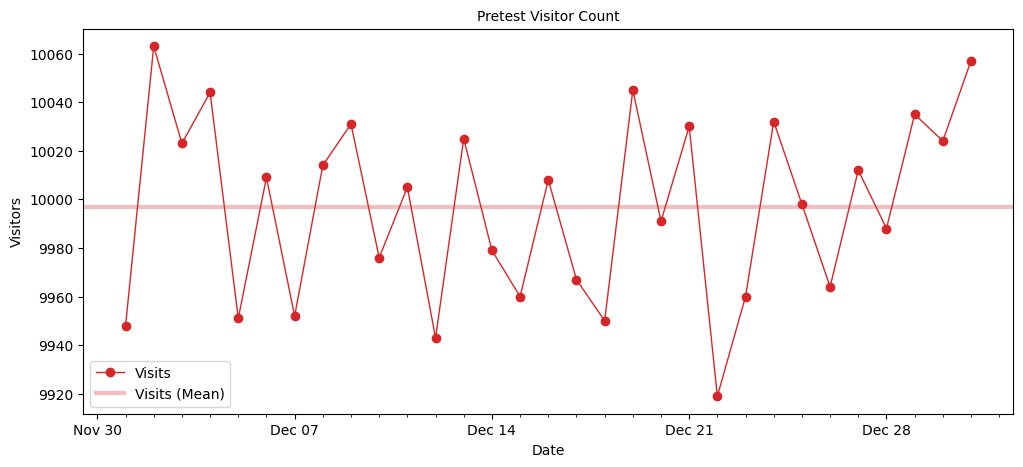

In [25]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[3], colors[4]

# Count sign-ups by date
visits_per_day = pretest.groupby('date')['submitted'].count()
visits_mean = visits_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(visits_per_day.index, visits_per_day, '-o', color=c1, linewidth=1, label='Visits')
plt.axhline(visits_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Visits (Mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Pretest Visitor Count', fontsize=10)
plt.ylabel('Visitors', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()

plt.show()

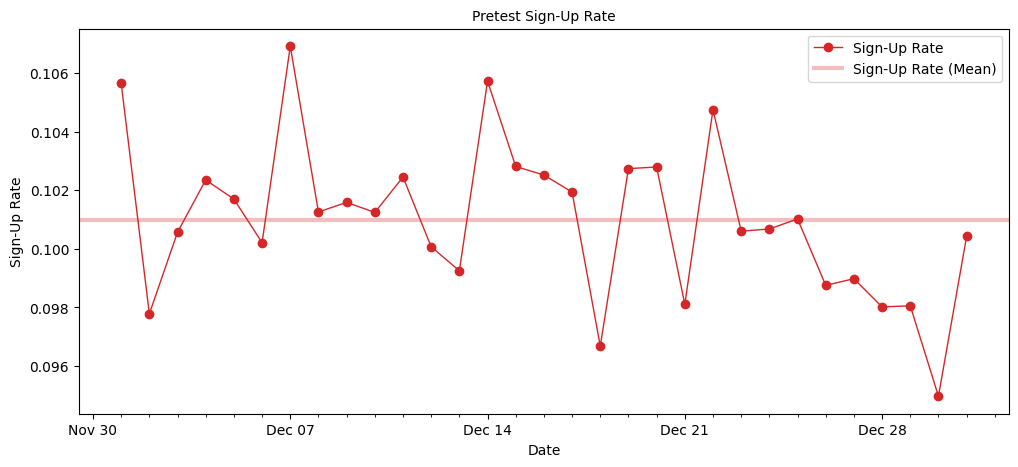

In [27]:
# Get the submission rate per date
signup_rate_per_day = pretest.groupby('date')['submitted'].mean() 
signup_rate_mean = signup_rate_per_day.mean() 

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(signup_rate_per_day.index, signup_rate_per_day, '-o', color=c1, linewidth=1, label='Sign-Up Rate')
plt.axhline(signup_rate_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Sign-Up Rate (Mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Pretest Sign-Up Rate', fontsize=10)
plt.ylabel('Sign-Up Rate', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()
plt.show()

# Hypothesis

In [29]:
# Experiment parameters
alpha = 0.05  
power = 0.80  
mde = 0.10    

# Proportions if the effect exists
p1 = 0.10           # Control   (Red)
p2 = p1 * (1 + p1)  # Treatment (Green)

# Experiment

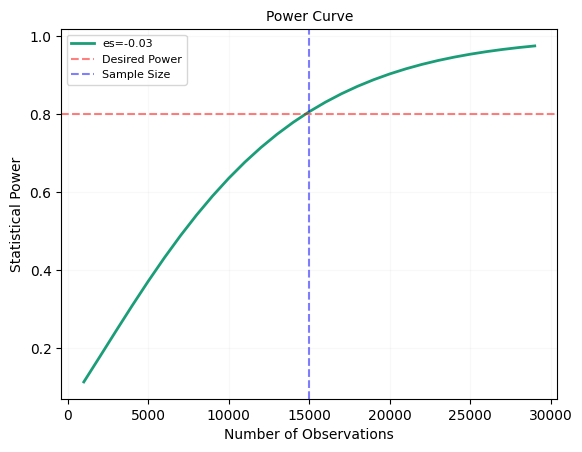

In [31]:
# Calculate the effect size using Cohen's D
cohen_D = sm.stats.proportion_effectsize(p1, p2)

# Estimate the sample size required per group
n = tt_ind_solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to the nearest thousand

# Explore power across sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5, color = 'red')
plt.axvline(n, linestyle='--', color='blue', label='Sample Size', alpha=0.5)
plt.ylabel('Statistical Power', fontsize =10)
plt.xlabel('Number of Observations', fontsize =10)
plt.title('Power Curve', fontsize =10)
plt.grid(alpha=0.08)
plt.legend(fontsize = 8)
plt.show()

#### Experiment Duration

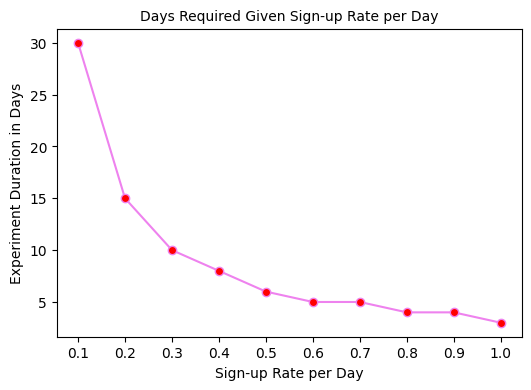

In [33]:
# what's the duration required to achieve the required sample size given the 
# percentage of unique visitors allocated to the experiment?

alloc = np.arange(0.10,1.1,0.10)
size = round(visits_mean, -3) * alloc
days = np.ceil(2*n / size)

# Generate plot
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(alloc, days, '-o', color = 'violet', markerfacecolor='red')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days Required Given Sign-up Rate per Day', fontsize=10)
ax.set_ylabel('Experiment Duration in Days',fontsize=10)
ax.set_xlabel('Sign-up Rate per Day',fontsize=10)
plt.show()

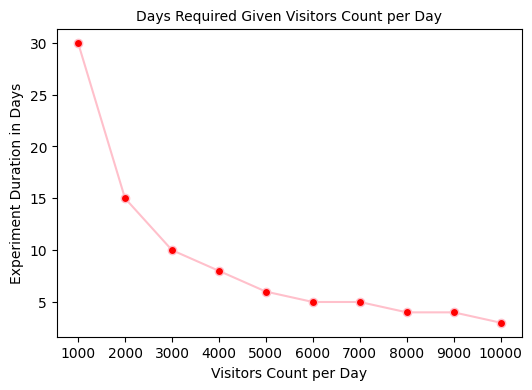

In [35]:
# what's the duration required to achieve the required sample size given the 
# number of unique visitors allocated to the experiment?

f, ax = plt.subplots(figsize=(6, 4))
ax.plot(size, days, '-o', color = 'pink', markerfacecolor='red')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.set_title('Days Required Given Visitors Count per Day',fontsize=10)
ax.set_ylabel('Experiment Duration in Days',fontsize=10)
ax.set_xlabel('Visitors Count per Day',fontsize=10)
plt.show()

# Experiment

In [37]:
# Get the subset tables of control and treatment results
AB_test = test[test.experiment == 'email_test']
control_signups = AB_test[AB_test.group == 0]['submitted']
treatment_signups = AB_test[AB_test.group == 1]['submitted']

# Get stats 
AB_control_cnt = control_signups.sum()          # Control Sign-Up Count
AB_treatment_cnt = treatment_signups.sum()      # Treatment Sign-Up Count
AB_control_rate = control_signups.mean()        # Control Sign-Up Rate
AB_treatment_rate = treatment_signups.mean()    # Treatment Sign-Up Rate
AB_control_size = control_signups.count()       # Control Sample Size 
AB_treatment_size = treatment_signups.count()   # Treatment Sample Size

# Show calculation
print(f'Control Sign-Up Rate: {AB_control_rate:.4}')
print(f'Treatment Sign-Up Rate: {AB_treatment_rate:.4}')

Control Sign-Up Rate: 0.09557
Treatment Sign-Up Rate: 0.1078


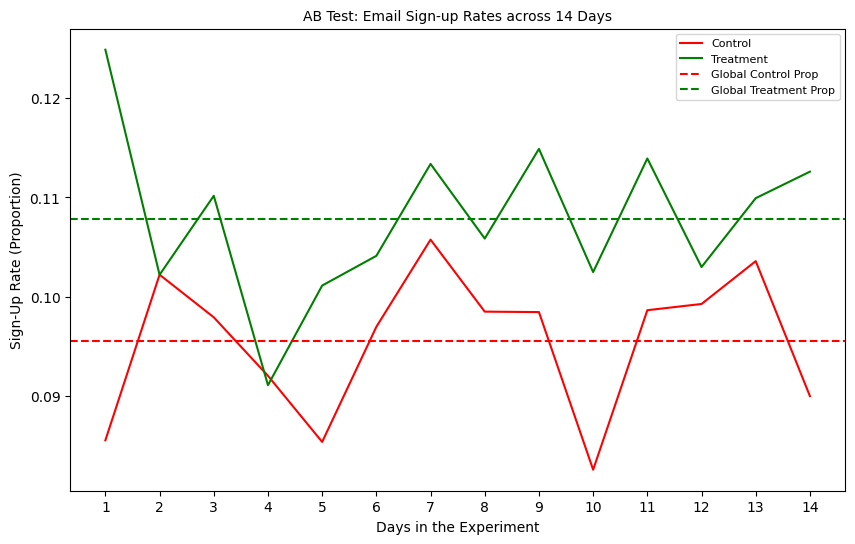

In [39]:
# Calculate the sign-up rates per date
signups_per_day = AB_test.groupby(['group','date'])['submitted'].mean()
ctrl_props = signups_per_day.loc[0]
trt_props = signups_per_day.loc[1]

# Get the day range of experiment
exp_days = range(1, AB_test['date'].nunique()+1 )

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, ctrl_props, label='Control', color='r')
ax.plot(exp_days, trt_props, label='Treatment', color='g')
ax.axhline(AB_control_rate, label='Global Control Prop', linestyle='--', color='r')
ax.axhline(AB_treatment_rate, label='Global Treatment Prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('AB Test: Email Sign-up Rates across 14 Days', fontsize = 10)
ax.set_ylabel('Sign-Up Rate (Proportion)', fontsize = 10)
ax.set_xlabel('Days in the Experiment', fontsize = 10)
ax.legend(fontsize = 8)
plt.show()

# Validity Threats

## AA Test

In [41]:
# Let's conduct an AA test

# Filter on visitors in the AA test 
AA_test = pretest[pretest.experiment == 'AA_test']

# Grab the control and treatment groups in the AA test
AA_control = AA_test[AA_test.group == 0]['submitted']
AA_treatment = AA_test[AA_test.group == 1]['submitted']

# Get stats
AA_control_cnt = AA_control.sum()
AA_treatment_cnt = AA_treatment.sum()
AA_control_rate = AA_control.mean()
AA_treatment_rate = AA_treatment.mean()
AA_control_size = AA_control.count()
AA_treatment_size = AA_treatment.count()

# Show calculation
print('-------- AA Test ----------')
print(f'Control Sign-Up Rate: {AA_control_rate:.3}')
print(f'Treatment Sign-Up Rate: {AA_treatment_rate:.3}')


-------- AA Test ----------
Control Sign-Up Rate: 0.101
Treatment Sign-Up Rate: 0.0988


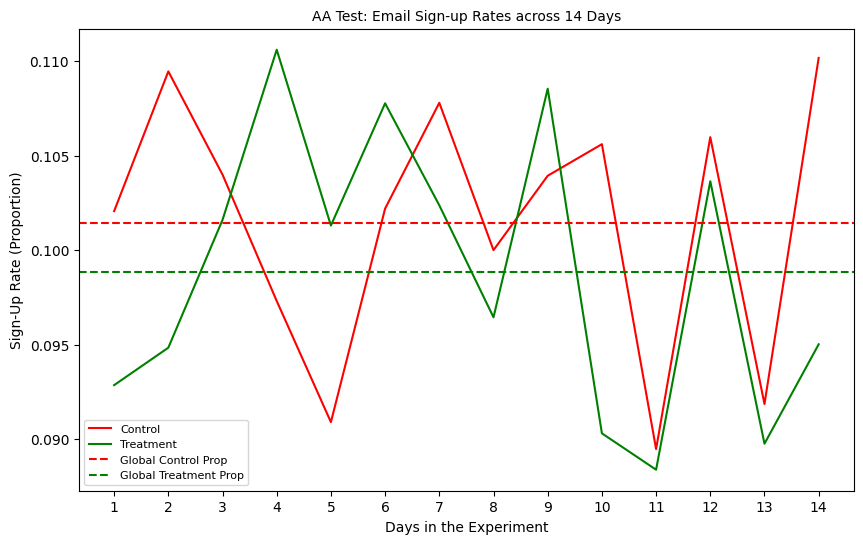

In [43]:
# Sign-up rates per date
AA_signups_per_day = AA_test.groupby(['group','date'])['submitted'].mean()
AA_ctrl_props = AA_signups_per_day.loc[0]
AA_trt_props = AA_signups_per_day.loc[1]

# Get the day range of experiment
exp_days = range(1, AA_test['date'].nunique() + 1)

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, AA_ctrl_props, label='Control', color='r')
ax.plot(exp_days, AA_trt_props, label='Treatment', color='g')
ax.axhline(AA_control_rate, label='Global Control Prop', linestyle='--', color='r')
ax.axhline(AA_treatment_rate, label='Global Treatment Prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('AA Test: Email Sign-up Rates across 14 Days', fontsize = 10)
ax.set_ylabel('Sign-Up Rate (Proportion)', fontsize = 10)
ax.set_xlabel('Days in the Experiment', fontsize = 10)
ax.legend(fontsize = 8)
plt.show()

In [45]:
# Run a chi-square test

# Execute test
AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_cnt, AA_treatment_cnt], nobs=[AA_control_size, AA_treatment_size])

# Grab dates
first_date = AA_test['date'].min().date()
last_date = AA_test['date'].max().date()

# Set the ALPHA for the AA test
AA_ALPHA = 0.05

print(f'-------- AA Test ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between red and green are the same.')
print('Ha: The sign-up rates between red and green are different.\n')
print(f'Significance level: {AA_ALPHA}')

print(f'Chi-Square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')

print('\nConclusion:')
if AA_pvalue < AA_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference between the two groups. Check for instrumentation errors.')
else:
  print('Fail to reject Ho. Therefore, proceed with the AB test.')

-------- AA Test (2021-12-18 - 2021-12-31)---------

Ho: The sign-up rates between red and green are the same.
Ha: The sign-up rates between red and green are different.

Significance level: 0.05
Chi-Square = 0.577 | P-value = 0.448

Conclusion:
Fail to reject Ho. Therefore, proceed with the AB test.


## Sample Ratio Mismatch (SRM)

In [47]:
# Let's check for sample ratio mismatch (SRM) 

# Set test param
SRM_ALPHA = 0.05

# Get the observed and expected counts in the experiment
email_test = test[test.experiment == 'email_test']
observed = email_test.groupby('group')['experiment'].count().values
expected = [email_test.shape[0]*0.5]*2

# perform Chi-Square Goodness of Fit Test
chi_stats, pvalue = stats.chisquare(f_obs=observed, f_exp=expected)

print('------- A Chi-Square Test for SRM --------\n')
print('Ho: The ratio of samples is 1:1.')
print('Ha: The ratio of samples is not 1:1.\n')
print(f'Significance level: {SRM_ALPHA}')

print(f'Chi-Square = {chi_stats:.3f} | P-value = {pvalue:.3f}')

print('\nConclusion:')
if pvalue < SRM_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the ratio of samples not being 1:1. Therefore, there is SRM.')
else:
  print('Fail to reject Ho. Therefore, there is no SRM.')

------- A Chi-Square Test for SRM --------

Ho: The ratio of samples is 1:1.
Ha: The ratio of samples is not 1:1.

Significance level: 0.05
Chi-Square = 1.290 | P-value = 0.256

Conclusion:
Fail to reject Ho. Therefore, there is no SRM.


# Statistical Inference

In [49]:
# Set the ALPHA for the AB test
AB_ALPHA = 0.05

## Chi-Squared Test

In [53]:
# Let's start with the chi-squared test

# Execute test
AB_chistats, AB_pvalue, AB_tab = proportions_chisquare([AB_control_cnt, AB_treatment_cnt], nobs=[AB_control_size, AB_treatment_size])

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Run results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between red and green are the same.')
print('Ha: The sign-up rates between red and green are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'Chi-Square = {AB_chistats:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between red and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: The sign-up rates between red and green are the same.
Ha: The sign-up rates between red and green are different.

Significance level: 0.05
Chi-Square = 12.312 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between red and green buttons.


## T-Test for Proportions

In [55]:
# Let's run T-Test for Proportions

# Execute test
AB_tstat, AB_pvalue, AB_df = ttest_ind(treatment_signups, control_signups)

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Print results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between red and green are the same.')
print('Ha: The sign-up rates between red and green are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'T-Statistic = {AB_tstat:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between red and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: The sign-up rates between red and green are the same.
Ha: The sign-up rates between red and green are different.

Significance level: 0.05
T-Statistic = 3.509 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between red and green buttons.


In [57]:
# Compute the Confidence Interval of the Test
ci = confint_proportions_2indep(AB_treatment_cnt, AB_treatment_size, AB_control_cnt, AB_control_size, method=None, compare='diff', alpha=0.05, correction=True)
lower = ci[0]
upper = ci[1]
lower_lift = ci[0] / AB_control_rate
upper_lift = ci[1] / AB_control_rate

In [59]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n--------- Sign-Up Counts (Rates) ----------')
print(f'Control: {AB_control_cnt} ({AB_control_rate*100:.1f}%)')
print(f'Treatment: {AB_treatment_cnt} ({AB_treatment_rate*100:.1f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {AB_treatment_rate - AB_control_rate:.4f}')
print(f'Relative (lift): {(AB_treatment_rate - AB_control_rate) / AB_control_rate*100:.1f}%')

print('\n--------- T-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 14942
Treatment: 15139

--------- Sign-Up Counts (Rates) ----------
Control: 1428 (9.6%)
Treatment: 1632 (10.8%)

--------- Differences ----------
Absolute: 0.0122
Relative (lift): 12.8%

--------- T-Stats ----------
Test Statistic: 3.509475
P-Value: 0.00045

--------- Confidence Intervals ----------
Absolute Difference CI: (0.005, 0.019)
Relative Difference (lift) CI: (5.7%, 19.9%)
